<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Загрузка датасета**

In [ ]:
import seaborn as sns
df = sns.load_dataset('iris')
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df[['species']]

**1. KNN**

Ниже реализован классификатор KNN.

Алгоритм:

1) Найти $k$ ближайших объектов для данного. Для подсчета расстояния использовано K Dimensional Tree.

2) Классифировать объект по наиболее часто встречающемуся классу из $k$ ближайших соседей.

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree

class KNNClassifier:
    """
    Классификатор, реализующий метод ближайших соседей
    """

    """
    Конструктор класса
    x - pandas.DataFrame с признаками
    y - pandas.Series с метками классов

    Сохраняет в класс признаки с метками, их длину, создает KDTree по признакам.
    """
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._tree = KDTree(x)
        self._size = len(x)
        self._train()

    """
    Метод вычисляющий оптимальное k.
    Реализован LOO. Берутся ближайшие соседи для удаленного элемента из KDTree.
    Создается словарь label_counter с счетчиком меток классов.
    Считаются потери, затем возвращается оптимальное k.
    """

    def _get_optimal_k(self):
        losses = [0] * (self._size - 1)

        for drop_index in range(self._size):
            distances = self._tree.query([self._x.iloc[drop_index].values], 
                                         k=self._size,
                                         return_distance=False).flatten()
            label_counter = {}
            for l_ind, df_ind in enumerate(distances[1:]):
                cur_label = self._y.iloc[df_ind].values[0]
                if cur_label not in label_counter:
                  label_counter[cur_label] = 0
                label_counter[cur_label] += 1
                
                answer = self._y.iloc[drop_index].values[0]
                predicted = max(label_counter, key=label_counter.get)
                losses[l_ind] += answer != predicted

        losses = [i / (self._size - 1) for i in losses]
        self._losses = losses
        return np.argmin(losses) + 1

    """
    Метод train вызывает подсчет оптимального k
    """

    def _train(self):
        self._k = self._get_optimal_k()

    """
    Метод visualize_training визуализирует потери для различных k.
    Использует данные о потерях сохраненные в _losses при подсчет оптимального k.
    """

    def visualize_training(self):
        x_axis = [tick for tick in range(self._size - 1)]
        plt.plot(x_axis, self._losses)
        plt.plot(self._k, self._losses[self._k - 1], 'go')
        plt.show()
        print(f'min at k = {self._k}')

    """
    Метод predict предсказывает метки классов для новых объектов.
    x_pred - pandas.DataFrame с признаками новых объектов.
    Достаются k ближайших объектов из KDTree. Считается самая частая метка
    при помощи метода idxmax (аналог argmin в pandas).
    Возвращается pandas.Series с предсказанными метками.
    """

    def predict(self, x_pred):
        predicted = []
        for obj in x_pred.values:
            distances = self._tree.query([obj], 
                                         k=self._k + 1,
                                         return_distance=False).flatten()
            labels = self._y.iloc[distances[1:]]
            predicted.append(labels.value_counts().idxmax(axis=0)[0])
        return pd.Series(predicted)

Время обучения модели:

In [ ]:
%time KNN = KNNClassifier(X, y)

CPU times: user 3.77 s, sys: 16.6 ms, total: 3.79 s
Wall time: 3.8 s


Визуализация потерь:

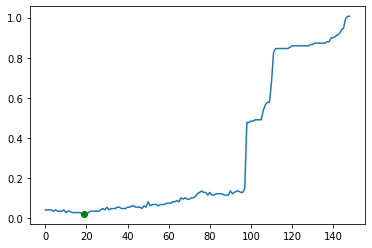

min at k = 19


In [ ]:
KNN.visualize_training()



---

**2. KwNN**

Ниже реализован классификатор KwNN.

Алгоритм:

1) Найти $k$ ближайших объектов для данного. Для подсчета расстояния использовано K Dimensional Tree.

2) Вес объекта считается функцией $q^i$.

2) Классифировать объект по наиболее часто встречающемуся классу из $k$ ближайших соседей.

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree

class KwNNClassifier:
    """
    Классификатор, реализующий метод ближайших соседей
    """

    """
    Конструктор класса
    x - pandas.DataFrame с признаками
    y - pandas.Series с метками классов

    Сохраняет в класс признаки с метками, их длину, создает KDTree по признакам.
    """

    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._tree = KDTree(x)
        self._size = len(x)
        self._train()

    """
    Метод вычисляющий оптимальные k и q.
    Реализован LOO, внутри которого перебираются различные q, для каждого
    находится оптимальный k. Берутся ближайшие соседи для удаленного элемента 
    из KDTree.
    Создается словарь label_counter с счетчиком меток классов.
    Считаются потери, затем возвращается оптимальное k.
    """

    def _get_optimal_opts(self, min_q=0.95, step_len=0.005, steps=13):
        self._min_q = min_q
        self._step = step_len
        q_losses = [0] * steps
        best_k = [0] * steps
        for q in range(steps):
          losses = [0] * (self._size - 1)
          for drop_index in range(self._size):
              distances = self._tree.query([self._x.iloc[drop_index].values], 
                                          k=self._size,
                                          return_distance=False).flatten()
              label_counter = {}
              for l_ind, df_ind in enumerate(distances[1:]):
                  cur_label = self._y.iloc[df_ind].values[0]
                  if cur_label not in label_counter:
                    label_counter[cur_label] = 0
                  label_counter[cur_label] += (min_q + q * step_len) ** l_ind
                  
                  answer = self._y.iloc[drop_index].values[0]
                  predicted = max(label_counter, key=label_counter.get)
                  losses[l_ind] += answer != predicted
          losses = [i / (self._size - 1) for i in losses]
          q_losses[q] = np.min(losses)
          best_k[q] = np.argmin(losses) + 1
        opt_q = min_q + step_len * (np.argmin(q_losses) + 1)
        opt_k = best_k[np.argmin(q_losses)]
        return opt_q, opt_k,

    """
    Метод train вызывает подсчет оптимального k
    """

    def _train(self):
        self._q, self._k = self._get_optimal_opts()

    """
    Метод training results выводит найденные оптимальные параметры модели
    """

    def training_results(self):
        print(f'min at q = {self._q}, k = {self._k}')

    """
    Метод predict предсказывает метки классов для новых объектов.
    x_pred - pandas.DataFrame с признаками новых объектов.
    Достаются k ближайших объектов из KDTree. Считается самая частая метка
    при помощи словарь с подсчетом их веса.
    Возвращается pandas.Series с предсказанными метками.
    """

    def predict(self, x_pred):
        predicted = []
        for obj in x_pred.values:
            distances = self._tree.query([obj], 
                                         k=self._k + 1,
                                         return_distance=False).flatten()
            label_counter = {}
            for l_ind, df_ind in enumerate(distances[1:]):
                cur_label = self._y.iloc[df_ind].values[0]
                if cur_label not in label_counter:
                  label_counter[cur_label] = 0
                label_counter[cur_label] += self._q ** l_ind
            predicted.append(max(label_counter, key=label_counter.get))
        return pd.Series(predicted)

Время обучения модели:

In [ ]:
%time KwNN = KwNNClassifier(X, y)

CPU times: user 45.7 s, sys: 114 ms, total: 45.8 s
Wall time: 45.8 s


Найденные оптимальные параметры:

In [ ]:
KwNN.training_results()

min at q = 0.965, k = 19


Функция для построения карты классификации

In [ ]:
from matplotlib.patches import Rectangle, Patch
from matplotlib.markers import MarkerStyle
import pandas as pd

"""
Функция построения карты классификации.
i - признак по оси OX
j - признак по оси OY
classifier - модель классификации

Функция формирует карты классификации с шагом 0.1
Объекты обучающей выборка представлены закрашенными кругами,
остальная область - незакрашенными.
"""

def draw_classification_map(i='sepal_length', j='sepal_width', 
                            classifier=KNNClassifier):
  KNN = classifier(X[[i, j]], y)
  color = {'virginica': 'blue', 'versicolor': 'red', 'setosa': 'green'}
  fig, ax = plt.subplots()

  for xi in np.arange(X[i].min(), X[i].max(), 0.1):
    for yi in np.arange(X[j].min(), X[j].max(), 0.1):
      cat = KNN.predict(pd.DataFrame([(xi, yi)]))
      # rect = Rectangle((xi, yi), 1, 1, color=color[cat.values[0]])
      # plt.gca().add_patch(rect)
      plt.scatter(xi, yi, color='none', 
                  edgecolor=color[cat.values[0]])

  for ind in range(len(X)):
    plt.scatter(X[i].values[ind], X[j].values[ind], 
               color=color[y.values[ind][0]])

  plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

  plt.xlim(X[i].min(), X[i].max())
  plt.ylim(X[j].min(), X[j].max())
  plt.show()
    

Сравним результат работы алгоритмов построив карту классификации на основе двух признаков:

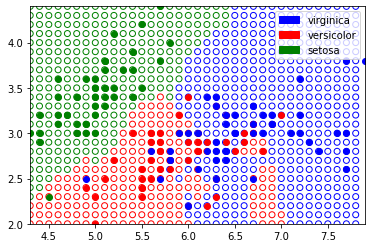

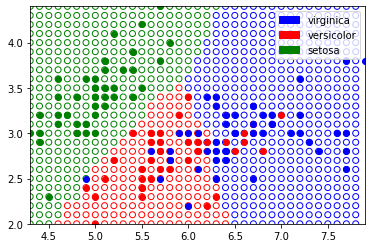

In [ ]:
draw_classification_map(classifier=KNNClassifier)
draw_classification_map(classifier=KwNNClassifier)

Шумовые объекты красного цвета повлияли на решение KNN и внутри синей области появилось еще красная. В KwNN такой проблемы нет. То есть даже на таком простом примере мы видим его преимущество. При росте числа объектов тестовой выборки оно будет увеличиваться.